In [58]:
import torch
from torch import nn
from sklearn.datasets import make_circles
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split

In [59]:
n_samples = 1000
X,y = make_circles(n_samples=n_samples, noise=0.05, random_state=42)
len(X), len(y)

(1000, 1000)

In [60]:
X = torch.from_numpy(X).type(torch.float32)
y = torch.from_numpy(y).type(torch.float32)

X[:5], y[:5]

(tensor([[ 0.7422,  0.2467],
         [-0.7340,  0.1687],
         [-0.8299,  0.2220],
         [-0.4291,  0.6722],
         [ 0.4456, -0.8949]]),
 tensor([1., 1., 1., 1., 0.]))

In [61]:
print(f"first 5 samples of X {X[:5]}")
print(f"first 5 samples of y {y[:5]}")

first 5 samples of X tensor([[ 0.7422,  0.2467],
        [-0.7340,  0.1687],
        [-0.8299,  0.2220],
        [-0.4291,  0.6722],
        [ 0.4456, -0.8949]])
first 5 samples of y tensor([1., 1., 1., 1., 0.])


In [62]:
circles = pd.DataFrame({"X1" : X[:, 0], "X2" : X[:,1], "label" : y})
circles.head(20)

,X1,X2,label
0,0.742207,0.246686,1.0
1,-0.734032,0.168692,1.0
2,-0.829859,0.221959,1.0
3,-0.429136,0.672230,1.0
4,0.445602,-0.894936,0.0
5,-0.469885,0.708037,1.0
6,-0.016045,0.805623,1.0
7,0.759623,0.159526,1.0
8,-0.175692,-0.799837,1.0
9,-0.110616,1.042207,0.0


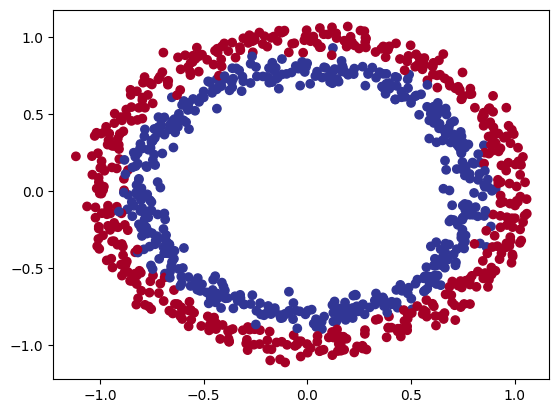

In [63]:

plt.scatter(x=X[:, 0], y=X[:, 1], c=y, cmap=plt.cm.RdYlBu)

In [64]:
X_train, X_test, y_train, y_test = train_test_split(X,y, test_size=0.2, random_state=42)
X_train.shape, X_test.shape, y_train.shape, y_test.shape

(torch.Size([800, 2]),
 torch.Size([200, 2]),
 torch.Size([800]),
 torch.Size([200]))

In [65]:
class CircleModelV0(nn.Module):
    def __init__(self):
        super().__init__()
        self.layer_1 = nn.Linear(in_features=2, out_features=5)
        self.layer_2 = nn.Linear(in_features=5, out_features=1)
    def forward(self, x):
        return self.layer_2(self.layer_1(x))


model_0 = CircleModelV0().to(device="cuda")
model_0
    


CircleModelV0(
  (layer_1): Linear(in_features=2, out_features=5, bias=True)
  (layer_2): Linear(in_features=5, out_features=1, bias=True)
)

In [66]:
model_0 = nn.Sequential(
    nn.Linear(in_features=2, out_features=5),
    nn.Linear(in_features=5, out_features=1)
)

model_0

Sequential(
  (0): Linear(in_features=2, out_features=5, bias=True)
  (1): Linear(in_features=5, out_features=1, bias=True)
)

In [67]:
loss_fn = nn.BCEWithLogitsLoss()
optimzer = torch.optim.SGD(params=model_0.parameters(), lr=0.1)


In [68]:
def accuracy_fn(y_true, y_preds):
    correct = torch.eq(y_true, y_preds).sum().item()
    acc = (correct / len(y_preds)) * 100
    return acc 

In [69]:
model_0.eval()
with torch.inference_mode():
    y_logits = model_0(X_test)[:5]
y_logits
    

tensor([[-0.0307],
        [-0.0213],
        [ 0.0896],
        [-0.0678],
        [ 0.3020]])

In [70]:
y_pred_probs = torch.sigmoid(y_logits)
y_pred_probs

tensor([[0.4923],
        [0.4947],
        [0.5224],
        [0.4831],
        [0.5749]])

In [71]:
torch.round(y_pred_probs)

tensor([[0.],
        [0.],
        [1.],
        [0.],
        [1.]])

In [73]:
torch.manual_seed(42)

epochs = 400

for epoch in range(epochs):
    model_0.train()

    y_logits = model_0(X_train).squeeze()
    y_pred = torch.round(torch.sigmoid(y_logits))

    loss = loss_fn(y_logits, y_train)
    acc = accuracy_fn(y_true=y_train, y_preds=y_pred)

    optimzer.zero_grad()

    loss.backward()

    optimzer.step()

    # testing
    model_0.eval()
    with torch.inference_mode():
        test_logits = model_0(X_test).squeeze()
        test_pred = torch.round(torch.sigmoid(test_logits))
        test_loss = loss_fn(test_logits, y_test)
        test_acc = accuracy_fn(y_true=y_test, y_preds=test_pred)
        
        print(f"Epoch: {epoch} |  Train loss: {loss:.5f} | Train acc: {acc:.2f}% | Test loss: {test_loss:.5f} | Test acc: {test_acc:.2f}%")

Epoch: 0 |  Train loss: 0.69773 | Train acc: 52.12% | Test loss: 0.69412 | Test acc: 57.50%
Epoch: 1 |  Train loss: 0.69746 | Train acc: 52.00% | Test loss: 0.69394 | Test acc: 56.50%
Epoch: 2 |  Train loss: 0.69721 | Train acc: 51.75% | Test loss: 0.69378 | Test acc: 56.50%
Epoch: 3 |  Train loss: 0.69699 | Train acc: 51.50% | Test loss: 0.69363 | Test acc: 57.00%
Epoch: 4 |  Train loss: 0.69678 | Train acc: 51.88% | Test loss: 0.69350 | Test acc: 56.00%
Epoch: 5 |  Train loss: 0.69658 | Train acc: 51.12% | Test loss: 0.69338 | Test acc: 55.50%
Epoch: 6 |  Train loss: 0.69640 | Train acc: 51.12% | Test loss: 0.69327 | Test acc: 55.00%
Epoch: 7 |  Train loss: 0.69623 | Train acc: 51.00% | Test loss: 0.69317 | Test acc: 54.50%
Epoch: 8 |  Train loss: 0.69608 | Train acc: 50.88% | Test loss: 0.69307 | Test acc: 54.50%
Epoch: 9 |  Train loss: 0.69593 | Train acc: 51.25% | Test loss: 0.69299 | Test acc: 54.50%
Epoch: 10 |  Train loss: 0.69580 | Train acc: 51.12% | Test loss: 0.69292 | Test